# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count',
                  'synonyms_count', 'orthographic_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

Build our data.

In [3]:
def qposition(values, position):
    value = values[position]
    if np.isnan(value):
        return np.nan, np.nan
    finite_values = values[np.isfinite(values)]
    svalues = np.array(sorted(finite_values))
    length = len(svalues)
    ours = np.where(svalues == value)[0]
    return ours[0] / length, (ours[-1] + 1) / length

In [4]:
model = Model(time=Time.discrete, source=Source.majority, past=Past.last_bin, durl=Durl.all, max_distance=2)
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']

data = []

# First get the exact substitution ids so we can get a working progress bar
# in the next step.
with session_scope() as session:
    substitutions = session.query(Substitution.id)\
        .filter(Substitution.model == model)
    print("Got {} substitutions for model {}"
          .format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        # Prepare these arrays for use in stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start
                       + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        is_stopword = np.array([(lemma in stopwords)
                                or (token in stopwords)
                                for (lemma, token) in zip(lemmas, tokens)])
        
        for feature in Substitution.__features__:
            
            # Get feature values for the sentence and its words.
            sentence_values, _ = substitution.\
                source_destination_features(feature)
            sentence_values_rel, _ = substitution.\
                source_destination_features(feature,
                                            sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            words = getattr(substitution.source, source_type)[dslice]
            
            # Find the bins we'll use.
            # If there are only NaNs or only one feature value
            # we can't get bins on this sentence, so we want at least
            # 2 different feature values.
            # We also skip feature values if the source word is not coded
            # for the feature, as it would skew the 'appeared' 
            # distributions compared to the distribution of substituted
            # words. (For instance, the sum of categories would not be 
            # equal to the sum of H0s in the very last graphs, 
            # on sentencequantile. It also lets us make meaningful H0
            # comparison in all the other feature-based graphs.)
            non_sw_values = sentence_values.copy()
            non_sw_values[is_stopword] = np.nan
            non_sw_value_set = \
                set(non_sw_values[np.isfinite(non_sw_values)])
            if (len(non_sw_value_set) <= 1 or
                    np.isnan(sentence_values[substitution.position])):
                allnans = [np.nan] * len(non_sw_values)
                bins = allnans
                non_sw_values = allnans
                sentence_values = allnans
                sentence_values_rel = allnans
            else:
                bins = pd.cut(non_sw_values, BIN_COUNT, labels=False)
            
            # For each non-stopword, store its various properties.
            for i, (word, tag, skip) in enumerate(zip(words, tags,
                                                      is_stopword)):
                if skip:
                    # Drop any stopwords.
                    continue

                # Get a readable POS tag
                rtag = tag[0]
                rtag = 'Stopword-like' if rtag in stop_poses else rtag
                
                # Get the word's quantile position.
                start_quantile, stop_quantile = qposition(non_sw_values, i)

                # Store the word's properties.
                data.append({
                    'cluster_id': substitution.source.cluster.sid,
                    'destination_id': substitution.destination.sid,
                    'occurrence': substitution.occurrence,
                    'source_id': substitution.source.sid,
                    'position': substitution.position,
                    'feature': feature,
                    'word': word,
                    'POS': tag,
                    'rPOS': rtag,
                    'target': i == substitution.position,
                    'value': sentence_values[i],
                    'value_rel': sentence_values_rel[i],
                    'bin': bins[i],
                    'start_quantile': start_quantile,
                    'stop_quantile': stop_quantile,
                    'word_position': i
                })

words = pd.DataFrame(data)
del data

Got 9180 substitutions for model Model(time=Time.discrete, source=Source.majority, past=Past.last_bin, durl=Durl.all, max_distance=2)


  0% (   1 of 9180) |                      | Elapsed Time: 0:00:03 ETA:  9:52:55

  0% (  50 of 9180) |                      | Elapsed Time: 0:00:04 ETA:  0:03:04

  1% ( 115 of 9180) |                      | Elapsed Time: 0:00:05 ETA:  0:02:30

  2% ( 187 of 9180) |                      | Elapsed Time: 0:00:06 ETA:  0:02:19

  2% ( 230 of 9180) |                      | Elapsed Time: 0:00:07 ETA:  0:02:14

  3% ( 300 of 9180) |                      | Elapsed Time: 0:00:08 ETA:  0:02:11

  3% ( 345 of 9180) |                      | Elapsed Time: 0:00:09 ETA:  0:02:11

  4% ( 408 of 9180) |                      | Elapsed Time: 0:00:10 ETA:  0:02:11

  5% ( 459 of 9180) |#                     | Elapsed Time: 0:00:10 ETA:  0:02:08

  5% ( 528 of 9180) |#                     | Elapsed Time: 0:00:11 ETA:  0:02:06

  6% ( 574 of 9180) |#                     | Elapsed Time: 0:00:12 ETA:  0:01:58

  6% ( 637 of 9180) |#                     | Elapsed Time: 0:00:13 ETA:  0:01:59

  7% ( 689 of 9180) |#                     | Elapsed Time: 0:00:14 ETA:  0:01:58

  8% ( 777 of 9180) |#                     | Elapsed Time: 0:00:15 ETA:  0:01:54

  8% ( 804 of 9180) |#                     | Elapsed Time: 0:00:15 ETA:  0:01:53

  9% ( 879 of 9180) |##                    | Elapsed Time: 0:00:16 ETA:  0:01:50

 10% ( 918 of 9180) |##                    | Elapsed Time: 0:00:17 ETA:  0:01:53

 10% ( 986 of 9180) |##                    | Elapsed Time: 0:00:18 ETA:  0:01:54

 11% (1033 of 9180) |##                    | Elapsed Time: 0:00:19 ETA:  0:01:52

 12% (1108 of 9180) |##                    | Elapsed Time: 0:00:20 ETA:  0:01:52

 12% (1148 of 9180) |##                    | Elapsed Time: 0:00:20 ETA:  0:01:50

 13% (1216 of 9180) |##                    | Elapsed Time: 0:00:21 ETA:  0:01:49

 13% (1263 of 9180) |###                   | Elapsed Time: 0:00:22 ETA:  0:01:50

 14% (1336 of 9180) |###                   | Elapsed Time: 0:00:23 ETA:  0:01:48

 15% (1377 of 9180) |###                   | Elapsed Time: 0:00:23 ETA:  0:01:49

 15% (1456 of 9180) |###                   | Elapsed Time: 0:00:24 ETA:  0:01:40

 16% (1492 of 9180) |###                   | Elapsed Time: 0:00:25 ETA:  0:01:39

 16% (1554 of 9180) |###                   | Elapsed Time: 0:00:26 ETA:  0:01:42

 17% (1607 of 9180) |###                   | Elapsed Time: 0:00:27 ETA:  0:01:42

 18% (1683 of 9180) |####                  | Elapsed Time: 0:00:28 ETA:  0:01:40

 18% (1722 of 9180) |####                  | Elapsed Time: 0:00:28 ETA:  0:01:39

 19% (1797 of 9180) |####                  | Elapsed Time: 0:00:29 ETA:  0:01:39

 20% (1836 of 9180) |####                  | Elapsed Time: 0:00:30 ETA:  0:01:39

 20% (1917 of 9180) |####                  | Elapsed Time: 0:00:31 ETA:  0:01:35

 21% (1951 of 9180) |####                  | Elapsed Time: 0:00:31 ETA:  0:01:36

 21% (1991 of 9180) |####                  | Elapsed Time: 0:00:32 ETA:  0:01:44

 22% (2066 of 9180) |####                  | Elapsed Time: 0:00:33 ETA:  0:01:39

 23% (2140 of 9180) |#####                 | Elapsed Time: 0:00:34 ETA:  0:01:37

 23% (2181 of 9180) |#####                 | Elapsed Time: 0:00:35 ETA:  0:01:37

 24% (2246 of 9180) |#####                 | Elapsed Time: 0:00:36 ETA:  0:01:37

 25% (2295 of 9180) |#####                 | Elapsed Time: 0:00:37 ETA:  0:01:45

 25% (2382 of 9180) |#####                 | Elapsed Time: 0:00:38 ETA:  0:01:42

 26% (2410 of 9180) |#####                 | Elapsed Time: 0:00:38 ETA:  0:01:40

 27% (2487 of 9180) |#####                 | Elapsed Time: 0:00:39 ETA:  0:01:28

 27% (2525 of 9180) |######                | Elapsed Time: 0:00:40 ETA:  0:01:28

 28% (2605 of 9180) |######                | Elapsed Time: 0:00:41 ETA:  0:01:25

 28% (2640 of 9180) |######                | Elapsed Time: 0:00:41 ETA:  0:01:24

 29% (2713 of 9180) |######                | Elapsed Time: 0:00:42 ETA:  0:01:21

 30% (2754 of 9180) |######                | Elapsed Time: 0:00:43 ETA:  0:01:13

 30% (2822 of 9180) |######                | Elapsed Time: 0:00:44 ETA:  0:01:14

 31% (2869 of 9180) |######                | Elapsed Time: 0:00:44 ETA:  0:01:18

 32% (2941 of 9180) |#######               | Elapsed Time: 0:00:45 ETA:  0:01:18

 32% (2984 of 9180) |#######               | Elapsed Time: 0:00:46 ETA:  0:01:18

 33% (3055 of 9180) |#######               | Elapsed Time: 0:00:47 ETA:  0:01:18

 33% (3099 of 9180) |#######               | Elapsed Time: 0:00:48 ETA:  0:01:20

 34% (3171 of 9180) |#######               | Elapsed Time: 0:00:49 ETA:  0:01:20

 35% (3213 of 9180) |#######               | Elapsed Time: 0:00:49 ETA:  0:01:19

 35% (3281 of 9180) |#######               | Elapsed Time: 0:00:50 ETA:  0:01:19

 36% (3328 of 9180) |#######               | Elapsed Time: 0:00:51 ETA:  0:01:18

 37% (3401 of 9180) |########              | Elapsed Time: 0:00:52 ETA:  0:01:15

 37% (3443 of 9180) |########              | Elapsed Time: 0:00:53 ETA:  0:01:17

 38% (3511 of 9180) |########              | Elapsed Time: 0:00:54 ETA:  0:01:18

 38% (3558 of 9180) |########              | Elapsed Time: 0:00:54 ETA:  0:01:15

 39% (3631 of 9180) |########              | Elapsed Time: 0:00:55 ETA:  0:01:13

 40% (3672 of 9180) |########              | Elapsed Time: 0:00:56 ETA:  0:01:13

 40% (3747 of 9180) |########              | Elapsed Time: 0:00:57 ETA:  0:01:12

 41% (3787 of 9180) |#########             | Elapsed Time: 0:00:57 ETA:  0:01:12

 41% (3848 of 9180) |#########             | Elapsed Time: 0:00:58 ETA:  0:01:14

 42% (3902 of 9180) |#########             | Elapsed Time: 0:00:59 ETA:  0:01:13

 43% (3971 of 9180) |#########             | Elapsed Time: 0:01:00 ETA:  0:01:10

 43% (4017 of 9180) |#########             | Elapsed Time: 0:01:01 ETA:  0:01:09

 44% (4087 of 9180) |#########             | Elapsed Time: 0:01:02 ETA:  0:01:10

 45% (4131 of 9180) |#########             | Elapsed Time: 0:01:02 ETA:  0:01:08

 45% (4213 of 9180) |##########            | Elapsed Time: 0:01:03 ETA:  0:01:04

 46% (4246 of 9180) |##########            | Elapsed Time: 0:01:04 ETA:  0:01:11

 47% (4330 of 9180) |##########            | Elapsed Time: 0:01:05 ETA:  0:01:06

 47% (4361 of 9180) |##########            | Elapsed Time: 0:01:06 ETA:  0:01:02

 48% (4433 of 9180) |##########            | Elapsed Time: 0:01:07 ETA:  0:01:02

 48% (4476 of 9180) |##########            | Elapsed Time: 0:01:07 ETA:  0:01:00

 49% (4557 of 9180) |##########            | Elapsed Time: 0:01:08 ETA:  0:00:57

 50% (4590 of 9180) |###########           | Elapsed Time: 0:01:09 ETA:  0:00:55

 50% (4671 of 9180) |###########           | Elapsed Time: 0:01:10 ETA:  0:00:54

 51% (4705 of 9180) |###########           | Elapsed Time: 0:01:10 ETA:  0:00:54

 52% (4779 of 9180) |###########           | Elapsed Time: 0:01:11 ETA:  0:00:46

 52% (4820 of 9180) |###########           | Elapsed Time: 0:01:12 ETA:  0:00:48

 53% (4881 of 9180) |###########           | Elapsed Time: 0:01:13 ETA:  0:00:50

 53% (4935 of 9180) |###########           | Elapsed Time: 0:01:13 ETA:  0:00:49

 54% (5009 of 9180) |############          | Elapsed Time: 0:01:14 ETA:  0:00:48

 55% (5049 of 9180) |############          | Elapsed Time: 0:01:15 ETA:  0:00:49

 55% (5125 of 9180) |############          | Elapsed Time: 0:01:16 ETA:  0:00:48

 56% (5164 of 9180) |############          | Elapsed Time: 0:01:16 ETA:  0:00:48

 57% (5255 of 9180) |############          | Elapsed Time: 0:01:17 ETA:  0:00:44

 57% (5279 of 9180) |############          | Elapsed Time: 0:01:18 ETA:  0:00:46

 58% (5351 of 9180) |############          | Elapsed Time: 0:01:19 ETA:  0:00:45

 58% (5394 of 9180) |############          | Elapsed Time: 0:01:19 ETA:  0:00:42

 59% (5462 of 9180) |#############         | Elapsed Time: 0:01:20 ETA:  0:00:43

 60% (5508 of 9180) |#############         | Elapsed Time: 0:01:21 ETA:  0:00:41

 60% (5575 of 9180) |#############         | Elapsed Time: 0:01:22 ETA:  0:00:42

 61% (5623 of 9180) |#############         | Elapsed Time: 0:01:23 ETA:  0:00:40

 62% (5704 of 9180) |#############         | Elapsed Time: 0:01:24 ETA:  0:00:39

 62% (5738 of 9180) |#############         | Elapsed Time: 0:01:24 ETA:  0:00:44

 63% (5812 of 9180) |#############         | Elapsed Time: 0:01:25 ETA:  0:00:40

 63% (5853 of 9180) |##############        | Elapsed Time: 0:01:26 ETA:  0:00:40

 64% (5941 of 9180) |##############        | Elapsed Time: 0:01:27 ETA:  0:00:35

 65% (5967 of 9180) |##############        | Elapsed Time: 0:01:27 ETA:  0:00:32

 65% (6051 of 9180) |##############        | Elapsed Time: 0:01:28 ETA:  0:00:30

 66% (6082 of 9180) |##############        | Elapsed Time: 0:01:28 ETA:  0:00:28

 67% (6166 of 9180) |##############        | Elapsed Time: 0:01:30 ETA:  0:00:28

 67% (6197 of 9180) |##############        | Elapsed Time: 0:01:30 ETA:  0:00:28

 68% (6286 of 9180) |###############       | Elapsed Time: 0:01:31 ETA:  0:00:23

 68% (6312 of 9180) |###############       | Elapsed Time: 0:01:31 ETA:  0:00:21

 69% (6383 of 9180) |###############       | Elapsed Time: 0:01:32 ETA:  0:00:21

 70% (6426 of 9180) |###############       | Elapsed Time: 0:01:33 ETA:  0:00:23

 70% (6492 of 9180) |###############       | Elapsed Time: 0:01:34 ETA:  0:00:26

 71% (6541 of 9180) |###############       | Elapsed Time: 0:01:35 ETA:  0:00:29

 72% (6610 of 9180) |###############       | Elapsed Time: 0:01:36 ETA:  0:00:28

 72% (6656 of 9180) |###############       | Elapsed Time: 0:01:36 ETA:  0:00:29

 73% (6734 of 9180) |################      | Elapsed Time: 0:01:37 ETA:  0:00:27

 73% (6771 of 9180) |################      | Elapsed Time: 0:01:38 ETA:  0:00:30

 74% (6855 of 9180) |################      | Elapsed Time: 0:01:39 ETA:  0:00:27

 75% (6885 of 9180) |################      | Elapsed Time: 0:01:39 ETA:  0:00:25

 75% (6974 of 9180) |################      | Elapsed Time: 0:01:40 ETA:  0:00:20

 76% (7000 of 9180) |################      | Elapsed Time: 0:01:40 ETA:  0:00:17

 76% (7062 of 9180) |################      | Elapsed Time: 0:01:41 ETA:  0:00:17

 77% (7115 of 9180) |#################     | Elapsed Time: 0:01:42 ETA:  0:00:18

 78% (7193 of 9180) |#################     | Elapsed Time: 0:01:43 ETA:  0:00:17

 78% (7230 of 9180) |#################     | Elapsed Time: 0:01:44 ETA:  0:00:16

 79% (7306 of 9180) |#################     | Elapsed Time: 0:01:45 ETA:  0:00:15

 80% (7344 of 9180) |#################     | Elapsed Time: 0:01:45 ETA:  0:00:15

 80% (7425 of 9180) |#################     | Elapsed Time: 0:01:46 ETA:  0:00:14

 81% (7459 of 9180) |#################     | Elapsed Time: 0:01:47 ETA:  0:00:16

 82% (7538 of 9180) |##################    | Elapsed Time: 0:01:48 ETA:  0:00:15

 82% (7574 of 9180) |##################    | Elapsed Time: 0:01:48 ETA:  0:00:11

 83% (7627 of 9180) |##################    | Elapsed Time: 0:01:49 ETA:  0:00:16

 83% (7689 of 9180) |##################    | Elapsed Time: 0:01:50 ETA:  0:00:14

 84% (7764 of 9180) |##################    | Elapsed Time: 0:01:51 ETA:  0:00:14

 85% (7803 of 9180) |##################    | Elapsed Time: 0:01:52 ETA:  0:00:14

 85% (7888 of 9180) |##################    | Elapsed Time: 0:01:53 ETA:  0:00:11

 86% (7918 of 9180) |##################    | Elapsed Time: 0:01:53 ETA:  0:00:12

 87% (7994 of 9180) |###################   | Elapsed Time: 0:01:54 ETA:  0:00:11

 87% (8033 of 9180) |###################   | Elapsed Time: 0:01:54 ETA:  0:00:11

 88% (8109 of 9180) |###################   | Elapsed Time: 0:01:55 ETA:  0:00:10

 88% (8148 of 9180) |###################   | Elapsed Time: 0:01:56 ETA:  0:00:00

 89% (8226 of 9180) |###################   | Elapsed Time: 0:01:57 ETA:  0:00:01

 90% (8262 of 9180) |###################   | Elapsed Time: 0:01:57 ETA:  0:00:00

 90% (8341 of 9180) |###################   | Elapsed Time: 0:01:59 ETA:  0:00:00

 91% (8377 of 9180) |####################  | Elapsed Time: 0:01:59 ETA:  0:00:00

 92% (8458 of 9180) |####################  | Elapsed Time: 0:02:00 ETA:  0:00:00

 92% (8492 of 9180) |####################  | Elapsed Time: 0:02:00 ETA:  0:00:00

 93% (8577 of 9180) |####################  | Elapsed Time: 0:02:01 ETA:  0:00:00

 93% (8607 of 9180) |####################  | Elapsed Time: 0:02:02 ETA:  0:00:00

 94% (8688 of 9180) |####################  | Elapsed Time: 0:02:03 ETA:  0:00:00

 95% (8721 of 9180) |####################  | Elapsed Time: 0:02:03 ETA:  0:00:00

 96% (8815 of 9180) |##################### | Elapsed Time: 0:02:04 ETA:  0:00:00

 96% (8836 of 9180) |##################### | Elapsed Time: 0:02:04 ETA:  0:00:00

 97% (8929 of 9180) |##################### | Elapsed Time: 0:02:05 ETA:  0:00:00

 97% (8951 of 9180) |##################### | Elapsed Time: 0:02:06 ETA:  0:00:00

 98% (9032 of 9180) |##################### | Elapsed Time: 0:02:07 ETA:  0:00:00

 98% (9066 of 9180) |##################### | Elapsed Time: 0:02:07 ETA:  0:00:00

 99% (9142 of 9180) |##################### | Elapsed Time: 0:02:08 ETA:  0:00:00

100% (9180 of 9180) |######################| Elapsed Time: 0:02:09 Time: 0:02:09


Assign proper weight to each substitution.

In [5]:
divide_target_all_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_all).sum()
divide_target_feature_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_feature).sum()

# Weight is 1, at first (or 1 for feature-coded substitutions).
words['weight_all'] = 1
words['weight_feature'] = 1 * np.isfinite(words.value)

# Divided by the number of substitutions that share a durl.
print('Computing shared durl (all) weights')
words['weight_all'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared durl (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Divided by the number of substitutions that share a cluster.
# (Using divide_target_sum, where we divide by the sum of weights,
# ensures we count only one for each group of substitutions sharing
# a same durl.)
print('Computing shared cluster (all) weights')
words['weight_all'] = words\
    .groupby(['cluster_id', 'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared cluster (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['cluster_id', 'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Add a weight measure for word appearances, weighing a word
# by the number of words that appear with it in its sentence.
# And the same for substitutions *whose source is coded by the feature*.
# (This lets us have the sum of categories equal the sum of H0s
# in the very last graphs [on sentencequantile], and make meaningful H0
# comparison values for all the other feature-based graphs.)
print('Computing appeared (all) weights')
words['weight_all_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_all']\
    .transform(lambda x: x / len(x))
print('Computing appeared (per-feature) weights')
words['weight_feature_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_feature']\
    .transform(lambda x: x / np.isfinite(words.loc[x.index].value).sum())

# In the above, note that when using a model that allows for multiple
# substitutions, those are stored as two separate substitutions in the
# database. This is ok, since we count the number of times a word is
# substituted compared to what it would have been substituted at
# random (i.e. we measure a bias, not a probability). Which leads us to
# count multiple substitutions in a same sentence as *different*
# substitutions, and to reflect this in the weights we must group
# substitutions by the position of the substituted word also (which is
# what we do here).

Computing shared durl (all) weights


Computing shared durl (per-feature) weights


Computing shared cluster (all) weights


Computing shared cluster (per-feature) weights


Computing appeared (all) weights


Computing appeared (per-feature) weights


Prepare feature ordering.

In [6]:
ordered_features = sorted(
    Substitution.__features__,
    key=lambda f: Substitution._transformed_feature(f).__doc__
)

Prepare counting functions.

In [7]:
target_all_counts = \
    lambda x: (x * words.loc[x.index, 'weight_all']).sum()
target_feature_counts = \
    lambda x: (x * words.loc[x.index, 'weight_feature']).sum()
appeared_all_counts = \
    lambda x: words.loc[x.index, 'weight_all_appeared'].sum()
appeared_feature_counts = \
    lambda x: words.loc[x.index, 'weight_feature_appeared'].sum()
susty_all = \
    lambda x: target_all_counts(x) / appeared_all_counts(x)
susty_feature = \
    lambda x: target_feature_counts(x) / appeared_feature_counts(x)

## 2 On POS

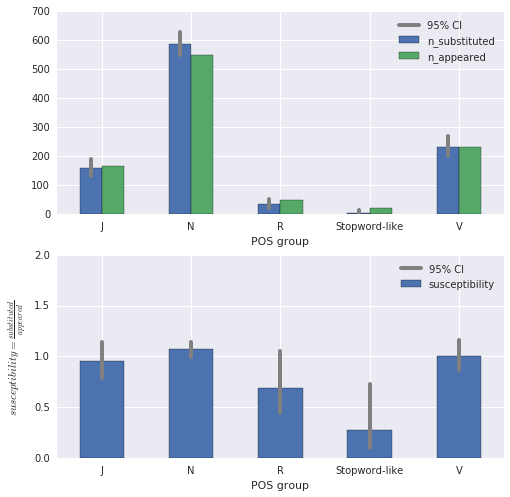

In [8]:
# Compute POS counts.
susties_pos = words[words.feature == 'aoa']\
    .groupby('rPOS')['target']\
    .aggregate({'susceptibility': susty_all,
                'n_substituted': target_all_counts,
                'n_appeared': appeared_all_counts})\
    .rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']]\
    .plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(),
                                      method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted,
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility']\
    .plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], (cis[i] * total_substituted 
                          / susties_pos.n_appeared.iloc[i]),
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-susceptibilities-pos'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the explanation below on confidence intervals (in section 3): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [9]:
# Test the n_substituted proportions are different from
# the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(
    susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['R', 'Stopword-like']


## 3 On global feature values

Prepare plotting functions, for bin and quartile susceptibilities for each feature.

In [10]:
def print_significance(feature, h0s, heights):
    h0_total = h0s.sum()
    bin_count = len(h0s)
    print()
    print('-' * len(feature))
    print(feature)
    print('-' * len(feature))
    for n_stars, alpha in enumerate([.05, .01, .001]):
        h0_cis = multinomial_proportions_confint(h0s.round(),
                                                 method='goodman',
                                                 alpha=alpha)
        differences = ((heights < h0_cis[:, 0] * h0_total)
                       | (heights > h0_cis[:, 1] * h0_total))
        are_different = np.any(differences)
        stars = ' ' * (3 - n_stars) + '*' * (1 + n_stars)
        if are_different:
            bins_different = np.where(differences)[0]
            bins_different += np.ones_like(bins_different)
            print(stars + ' Target different H_0 with p < {}.'
                  ' Bins [1; {}] out of region: {}'
                  .format(alpha, bin_count, bins_different.tolist()))
        else:
            print('     Target NOT different from H_0 (p > {})'
                  .format(alpha))
            break

In [11]:
def plot_bin_susties(**kwargs):
    data = kwargs['data']
    feature = data.iloc[0].feature
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    quantiles = kwargs.get('quantiles', False)
    value = data.value_rel if relative else data.value
    
    # Compute binning.
    cut, cut_kws = ((pd.qcut, {}) if quantiles
                    else (pd.cut, {'right': False}))
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            value_bins, bins = cut(value, bin_count, labels=False,
                                   retbins=True, **cut_kws)
            break
        except ValueError:
            pass
    middles = (bins[:-1] + bins[1:]) / 2

    # Compute bin counts. Note here the bins are computed on the
    # distribution of observed substitutions, not the simulated aggregated
    # distributions of cluster-unit substitutions. But since it's mostly
    # deduplication that the aggregation process addresses, the bins
    # should be mostly the same. This could be corrected by computing
    # bins on the aggregate distribution (not hard), but it's really
    # not important now.
    heights = np.zeros(bin_count)
    h0s = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = (data[data.target & (value_bins == i)]
                      .weight_feature.sum())
        h0s[i] = data[value_bins == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = (r'\sigma_{\phi'
                + ('_r' if relative else '')
                + '}')
    plt.plot(middles, heights / h0s, 
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(middles, np.ones_like(middles), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, 2)
    
    # Test for statistical significance
    print_significance(feature, h0s, heights)

In [12]:
def plot_grid(data, features, filename,
              plot_function, xlabel, ylabel, plot_kws={}):
    g = sb.FacetGrid(data=data[data['feature']
                               .map(lambda f: f in features)],
                     sharex=False, sharey=True,
                     col='feature', hue='feature',
                     col_order=features, hue_order=features,
                     col_wrap=3, aspect=1.5, size=3)
    g.map_dataframe(plot_function, **plot_kws)
    g.set_titles('{col_name}')
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)
    for ax in g.axes.ravel():
        legend = ax.legend(frameon=True, loc='best')
        if not legend:
            # Skip if nothing was plotted on these axes.
            continue
        frame = legend.get_frame()
        frame.set_facecolor('#f2f2f2')
        frame.set_edgecolor('#000000')
        ax.set_title(Substitution._transformed_feature(ax.get_title())
                     .__doc__)
    if SAVE_FIGURES:
        g.fig.savefig(settings.FIGURE.format(filename),
                      bbox_inches='tight', dpi=300)

### 3.1 Bins of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
     Target NOT different from H_0 (p > 0.001)

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [3]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 4]

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.01)



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


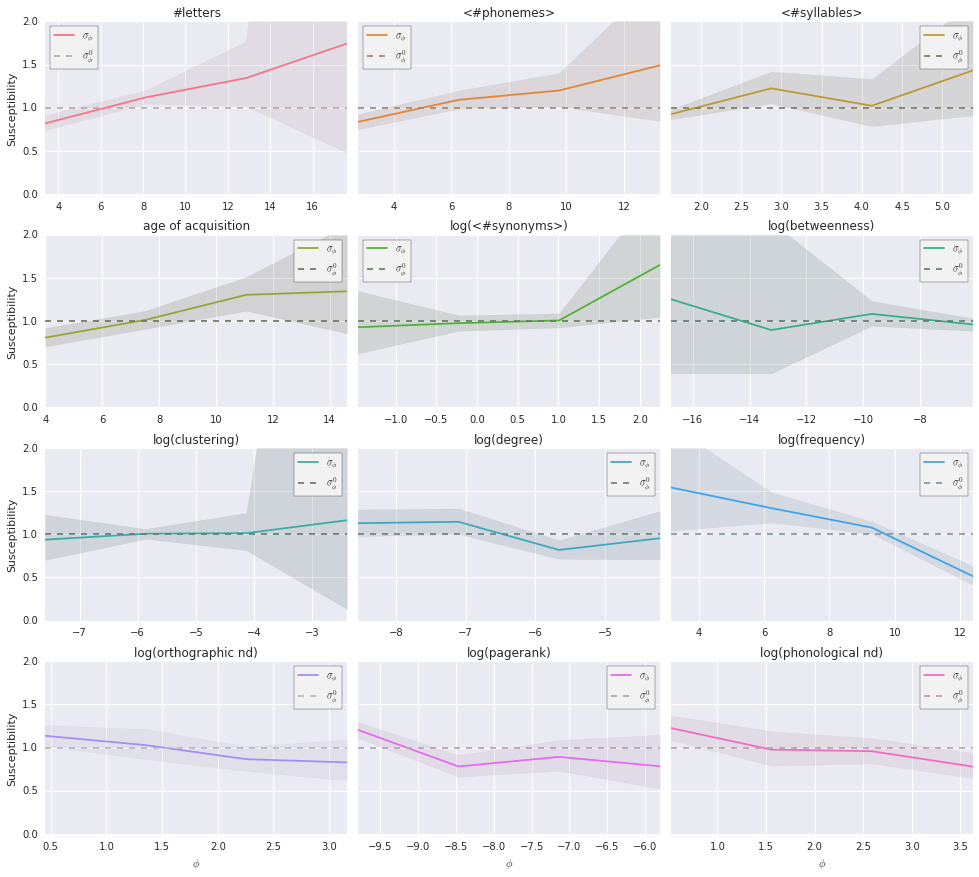

In [13]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

**Note on how graphs and their confidence intervals are computed here**

There are three ways I can do a computation like above:

(1) For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.

(2) Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma_{\phi}(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. In each bin $b_i$ we have:

$$\left< \sigma_{\phi}(f) \right>_{f \in b_i}$$

The problem with both (1) and (2) is that there's no proper $\mathcal{H}_0$ value, because the averages in the bins don't necessarily equal 1 under $\mathcal{H}_0$. Also, we can't check that there is consistency, showing that the sum of susceptibility values of the bins is 1. Hence case 3:

(3) Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not completely satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values, but it's what lets us compute proper null hypotheses: in each bin $b_i$ we have a value of $\sigma_{\phi}(b_i)$, and the sum of those should be the same under $\mathcal{H}_0$ as in the experiment (in practice in the graphs, we divide by the values under $\mathcal{H}_0$, and the reference is $\sigma_{\phi}^0(b_i) = 1$).

Here and below, we're always in case (3).


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]

----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]

--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.01)


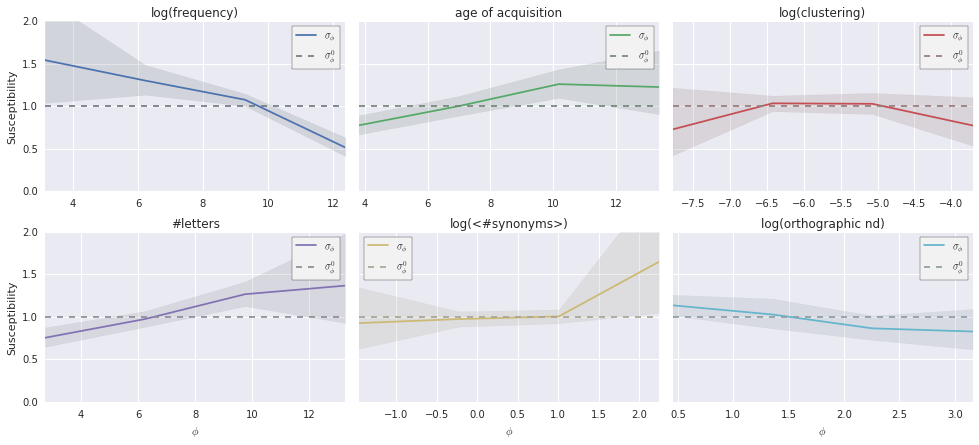

In [14]:
plot_grid(words[~(((words.feature == 'letters_count') 
                   & (words.value > 15))
                  | ((words.feature == 'aoa') 
                     & (words.value > 15))
                  | ((words.feature == 'clustering') 
                     & (words.value > -3)))],
          PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

### 3.2 Quantiles of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 2] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 2] out of region: [1, 2]
     Target NOT different from H_0 (p > 0.001)

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3]
     Target NOT different from H_0 (p > 0.01)



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 3] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 3] out of region: [3]
     Target NOT different from H_0 (p > 0.001)



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


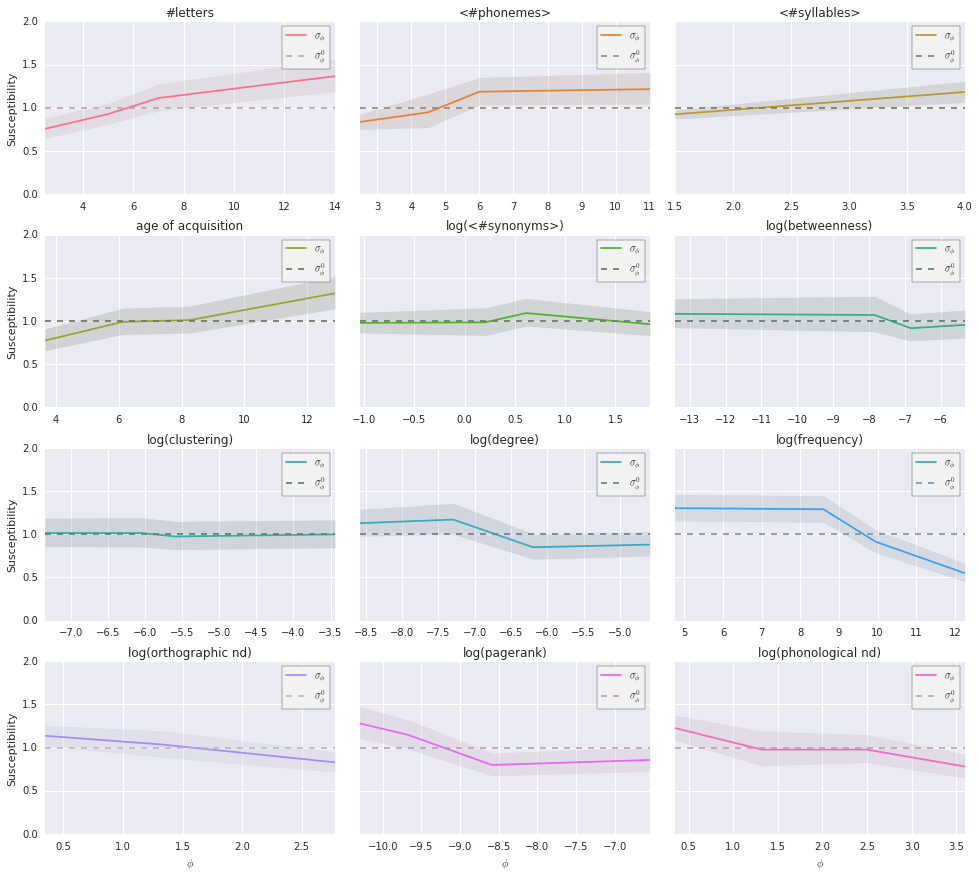

In [15]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

**Note on confidence intervals**

Here we're again in case (2) of the above explanation on confidence intervals (in section 3.1), since we're just binning by quantiles instead of fixed-width bins.


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 3] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 3] out of region: [3]
     Target NOT different from H_0 (p > 0.001)


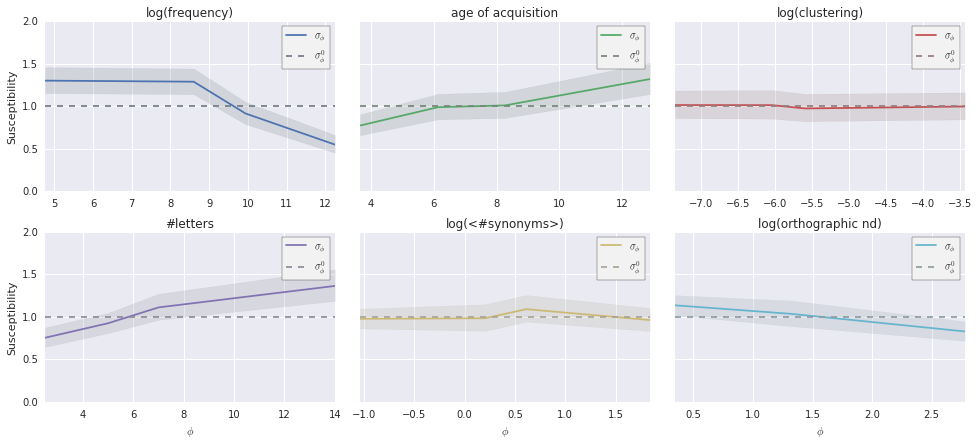

In [16]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

## 4 On sentence-relative feature values

### 4.1 Bins of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
     Target NOT different from H_0 (p > 0.001)

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3, 4]

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3]
     Target NOT different from H_0 (p > 0.001)

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]


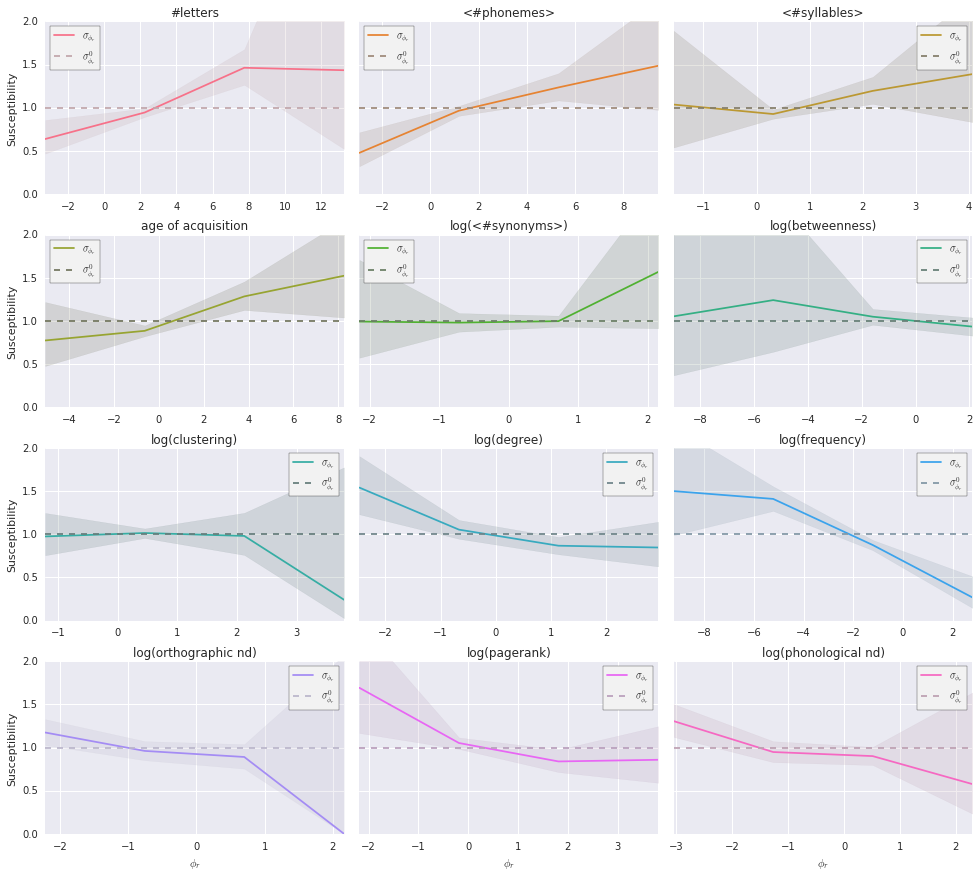

In [17]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]

----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]

--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]


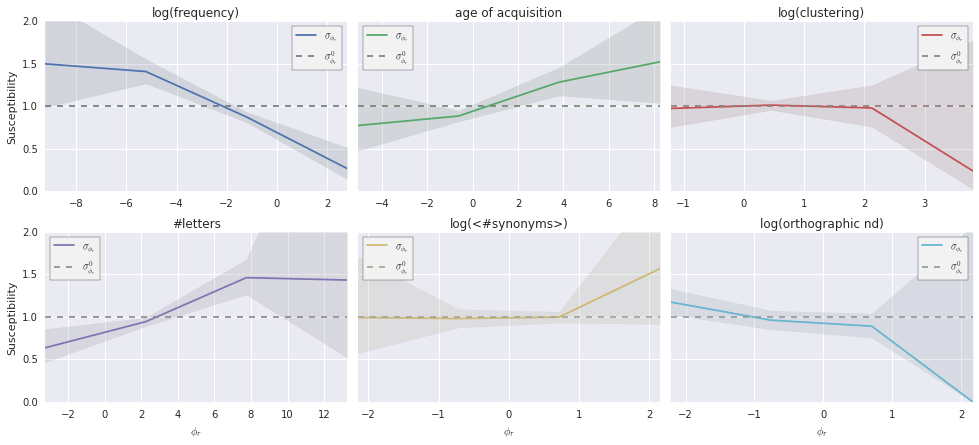

In [18]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})

### 4.2 Quantiles of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.001)

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.001)



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------------
orthographic_density
--------------------
     Target NOT different from H_0 (p > 0.05)



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


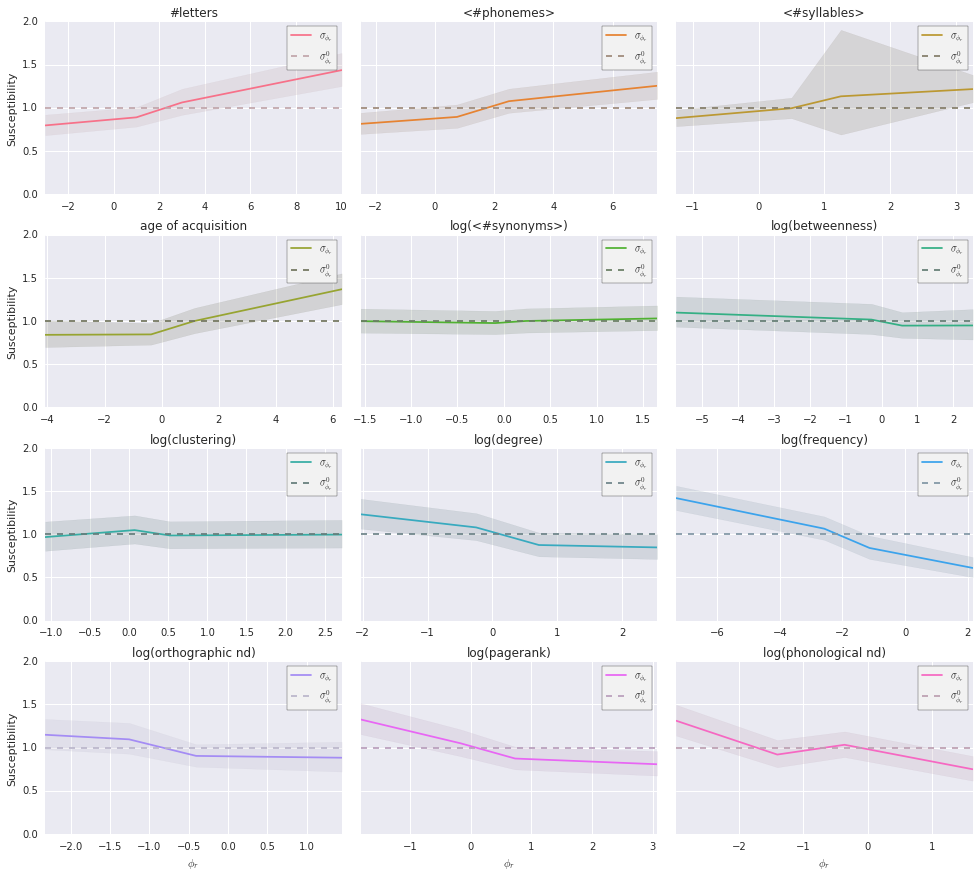

In [19]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

--------------------
orthographic_density
--------------------
     Target NOT different from H_0 (p > 0.05)


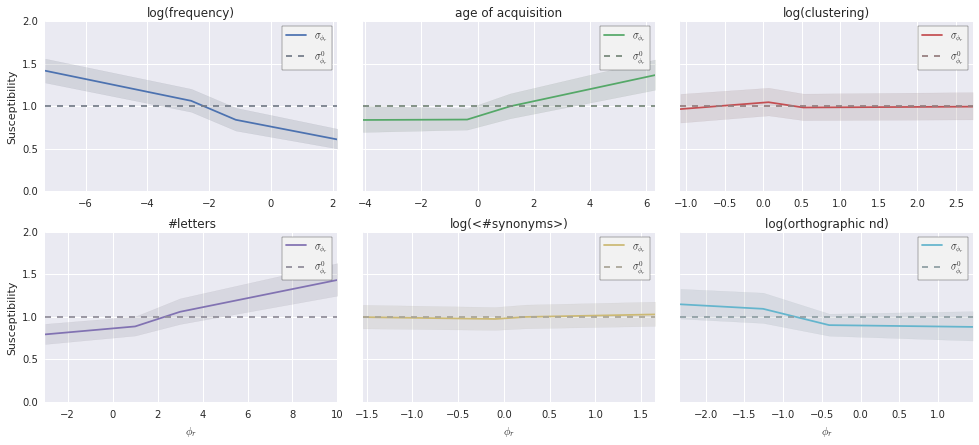

In [20]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})

## 5 On quantiles and bins of the in-sentence distributions

### 5.1 In-sentence bins (of distribution of values in each sentence)

In [21]:
def plot_sentencebin_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = (data[data.target & (data.bin == i)]
                      .weight_feature.sum())
        h0s[i] = data[data.bin == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{bin_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights / h0s, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, np.ones_like(x), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.01)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.01)



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


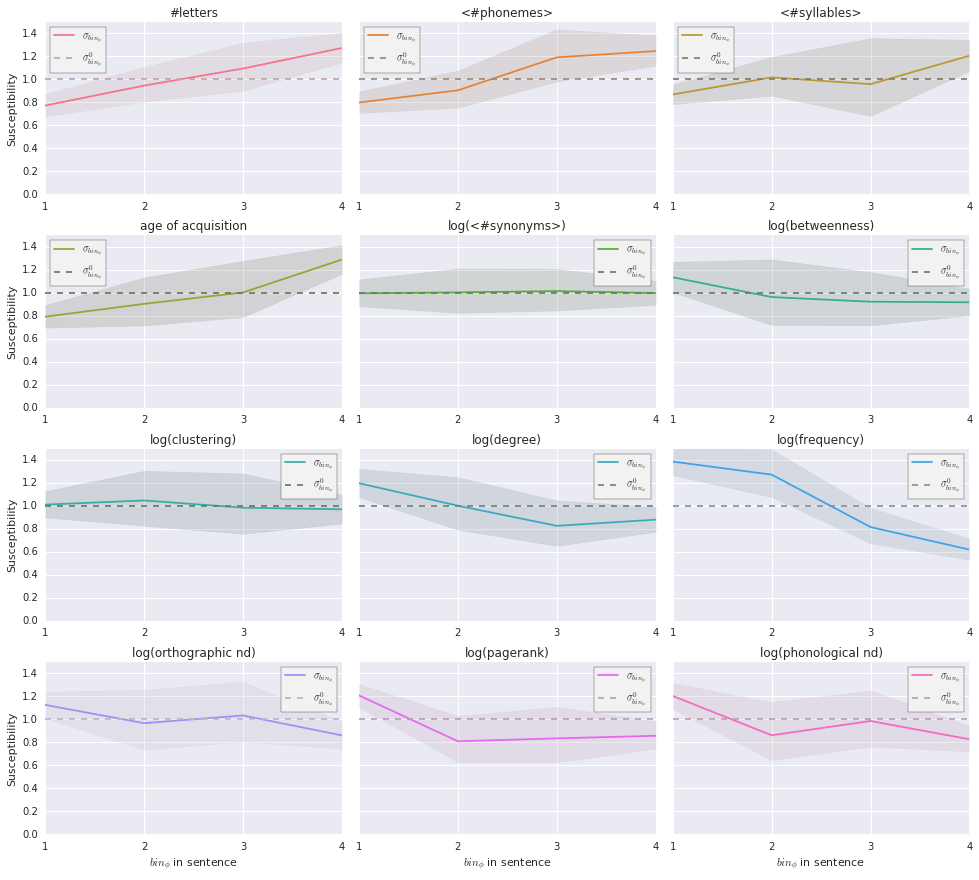

In [22]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.01)


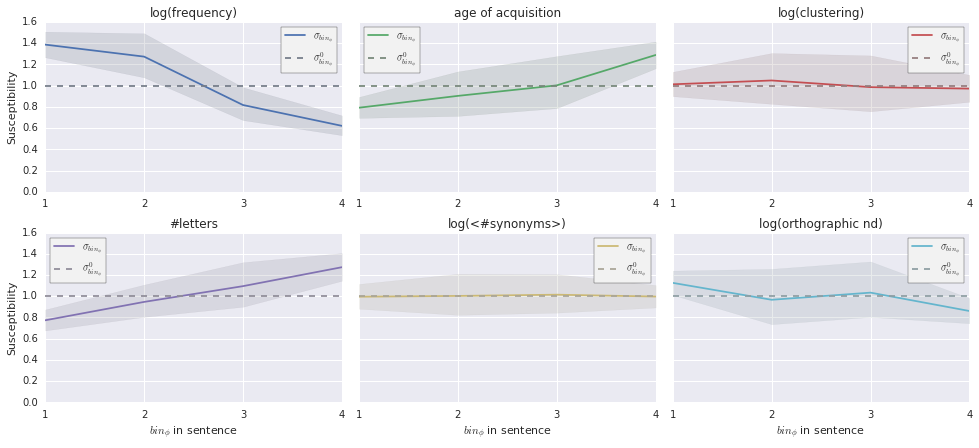

In [23]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')

### 5.2 In-sentence quantiles (of distribution of values in each sentence)

For each feature, count the sum of weights in each bin and plot that.

In [24]:
def bound(limits, values):
    left, right = limits
    assert left < right
    return np.maximum(left, np.minimum(right, values))

In [25]:
def plot_sentencequantile_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    step = 1 / BIN_COUNT
    for i in range(BIN_COUNT):
        limits = [i * step, (i + 1) * step]
        contributions = ((bound(limits, data.stop_quantile)
                          - bound(limits, data.start_quantile))
                         / (data.stop_quantile - data.start_quantile))
        heights[i] = \
            (contributions * data.weight_feature)[data.target].sum()
        h0s[i] = (contributions * data.weight_feature_appeared).sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total)# / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{q_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights,# / h0s,
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, h0s, '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.001)

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.01)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.001)



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]

--------------------
orthographic_density
--------------------
     Target NOT different from H_0 (p > 0.05)



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]


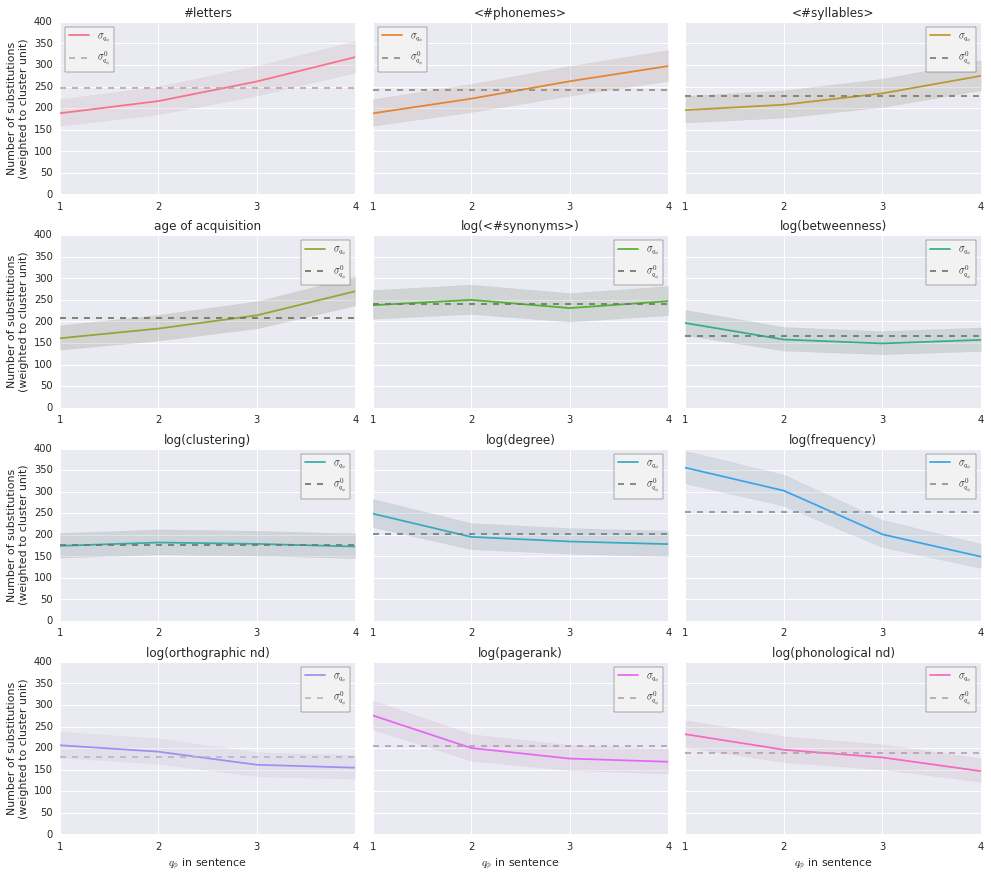

In [26]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

--------------------
orthographic_density
--------------------
     Target NOT different from H_0 (p > 0.05)


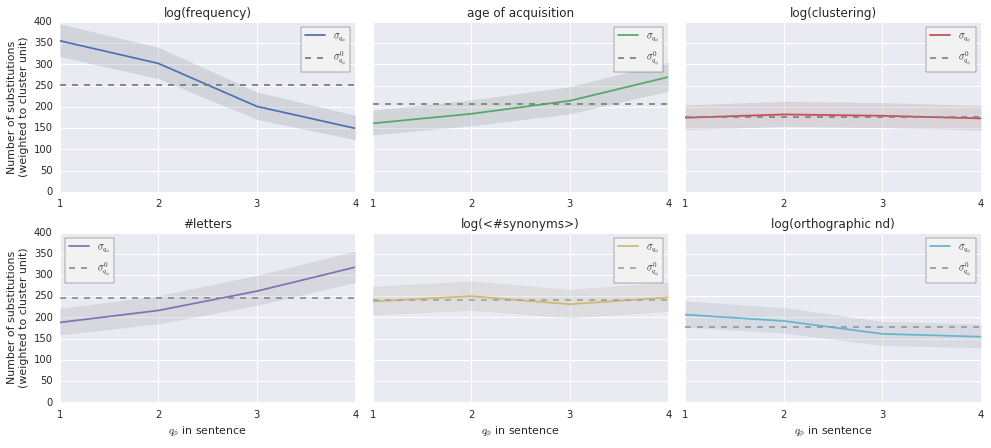

In [27]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')

## 6 Regression on significant features

### 6.1 Multinomial logistic regression

We try to predict which words are substituted, based on their global values, sentence-relative values, bins and quantiles of those, or in-sentence bin values.

Prediction is not good, mainly because the constraint of one-substitution-per-sentence can't be factored in the model simply. So precision is generally very low, around .20-.25, and when accuracy goes up recall plummets.

So it might show some interaction effects, but given that the fit is very bad I wouldn't trust it.

In-sentence quantiles (from section 5.2) were not done, as they're impossible to reduce to one value (our measure of those quantiles is in fact a subrange of [0, 1] for each word, corresponding to the subrange of the sentence distribution that that word's feature value represented).

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import binom_test

In [29]:
def regress_binning(data, features, value_funcs):
    # Compute bins
    data = data.copy()
    regress_features = [('{}'.format(value_name), feature)
                        for value_name in value_funcs.keys()
                        for feature in features]
    for i, (value_name, value_func) in enumerate(value_funcs.items()):
        data[value_name] = value_func(data)
    
    # Massage the dataframe to have feature bin as columns.
    data_wide = pd.pivot_table(
        data,
        values=list(value_funcs.keys()),
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[regress_features]

    # Add the target value.
    # Question/FIXME: should we use weight_appeared for regression?
    data_wide['target'] = pd.pivot_table(
        data,
        values=['target'],
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[('target', 'aoa')]
    data_wide = data_wide.dropna()

    # Compute polynomial features.
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    pdata = poly.fit_transform(data_wide[regress_features])
    pregress_features = [' * '.join(['_'.join(regress_features[j])
                                   for j, p in enumerate(powers)
                                   if p > 0]) or 'intercept'
                         for powers in poly.powers_]

    # Divide into two sets.
    print('Regressing with {} word measures (divided into'
          ' training and prediction sets)'
          .format(len(data_wide)))
    pdata_train = pdata[:len(data_wide) // 2]
    target_train = data_wide.iloc[:len(data_wide) // 2].target
    pdata_predict = pdata[len(data_wide) // 2:]
    target_predict = data_wide.iloc[len(data_wide) // 2:].target
    assert len(pdata_train) + len(pdata_predict) == len(data_wide)
    assert len(target_train) + len(target_predict) == len(data_wide)
    
    # Regress
    regressor = LogisticRegression(penalty='l2', class_weight='balanced',
                                   fit_intercept=False)
    regressor.fit(pdata_train, target_train)
    
    # And predict
    prediction = regressor.predict(pdata_predict)
    standard = target_predict.values
    success = prediction == standard
    
    tp = prediction & standard
    tn = (~prediction) & (~standard)
    fp = prediction & (~standard)
    fn = (~prediction) & standard
    
    print()
    print('{:.2f}% of words well predicted (non-random at p = {:.1})'
          .format(100 * success.mean(),
                  binom_test(success.sum(), len(success))))
    print('Precision = {:.2f}'.format(standard[prediction].mean()))
    print('Recall = {:.2f}'.format(prediction[standard].mean()))
    print()
    print('Coefficients:')
    print(pd.Series(index=pregress_features, data=regressor.coef_[0]))

**Global feature value**

In [30]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value})

Regressing with 26494 word measures (divided into training and prediction sets)

47.36% of words well predicted (non-random at p = 1e-09)
Precision = 0.23
Recall = 0.60

Coefficients:
intercept                                            -2.036421
global_frequency                                     -0.064574
global_aoa                                            0.215439
global_letters_count                                  0.402788
global_orthographic_density                          -0.014074
global_frequency * global_aoa                         0.018191
global_frequency * global_letters_count              -0.028945
global_frequency * global_orthographic_density        0.046330
global_aoa * global_letters_count                    -0.025146
global_aoa * global_orthographic_density             -0.094620
global_letters_count * global_orthographic_density    0.075604
dtype: float64


**Sentence-relative feature value**

In [31]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'sentence-rel': lambda d: d.value_rel})

Regressing with 26494 word measures (divided into training and prediction sets)

57.55% of words well predicted (non-random at p = 7e-68)
Precision = 0.23
Recall = 0.41

Coefficients:
intercept                                                        -0.034090
sentence-rel_frequency                                            0.068001
sentence-rel_aoa                                                  0.062958
sentence-rel_letters_count                                        0.025269
sentence-rel_orthographic_density                                 0.127676
sentence-rel_frequency * sentence-rel_aoa                         0.000038
sentence-rel_frequency * sentence-rel_letters_count              -0.065708
sentence-rel_frequency * sentence-rel_orthographic_density        0.032012
sentence-rel_aoa * sentence-rel_letters_count                    -0.030034
sentence-rel_aoa * sentence-rel_orthographic_density             -0.092998
sentence-rel_letters_count * sentence-rel_orthographic_density    

**Global + sentence-relative feature values**

In [32]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value,
                 'sentence-rel': lambda d: d.value_rel})

Regressing with 26494 word measures (divided into training and prediction sets)



57.06% of words well predicted (non-random at p = 1e-59)
Precision = 0.25
Recall = 0.49

Coefficients:
intercept                                                         -1.131203
global_frequency                                                   0.139560
global_aoa                                                        -0.119927
global_letters_count                                              -0.189247
global_orthographic_density                                        0.265583
sentence-rel_frequency                                             0.200802
sentence-rel_aoa                                                   0.464094
sentence-rel_letters_count                                         1.093154
sentence-rel_orthographic_density                                  0.864616
global_frequency * global_aoa                                      0.001415
global_frequency * global_letters_count                            0.028119
global_frequency * global_orthographic_density              

**(3.1) Bins of distribution of appeared global feature values**

In [33]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-global':
                     lambda d: pd.cut(d.value, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 26494 word measures (divided into training and prediction sets)

43.16% of words well predicted (non-random at p = 5e-56)
Precision = 0.24
Recall = 0.75

Coefficients:
intercept                                                      -0.387913
bins-global_frequency                                          -0.099637
bins-global_aoa                                                 2.666272
bins-global_letters_count                                      -0.541538
bins-global_orthographic_density                               -2.186483
bins-global_frequency * bins-global_aoa                        -0.648723
bins-global_frequency * bins-global_letters_count               0.269302
bins-global_frequency * bins-global_orthographic_density        0.347920
bins-global_aoa * bins-global_letters_count                    -0.476326
bins-global_aoa * bins-global_orthographic_density             -0.059361
bins-global_letters_count * bins-global_orthographic_density    0.745282
dtype: float6

**(3.2) Quantiles of distribution of appeared global feature values**

In [34]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-global':
                     lambda d: pd.qcut(d.value, BIN_COUNT, labels=False)})

Regressing with 26494 word measures (divided into training and prediction sets)

62.69% of words well predicted (non-random at p = 2e-189)
Precision = 0.30
Recall = 0.56

Coefficients:
intercept                                                                 1.378219
quantiles-global_frequency                                               -0.233740
quantiles-global_aoa                                                      0.949602
quantiles-global_letters_count                                           -0.491177
quantiles-global_orthographic_density                                    -2.901679
quantiles-global_frequency * quantiles-global_aoa                        -0.582754
quantiles-global_frequency * quantiles-global_letters_count              -0.018432
quantiles-global_frequency * quantiles-global_orthographic_density        1.288157
quantiles-global_aoa * quantiles-global_letters_count                     0.428243
quantiles-global_aoa * quantiles-global_orthographic_density        

**(4.1) Bins of distribution of appeared sentence-relative values**

In [35]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-sentence-rel':
                     lambda d: pd.cut(d.value_rel, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 26494 word measures (divided into training and prediction sets)

67.61% of words well predicted (non-random at p = 5e-324)
Precision = 0.23
Recall = 0.21

Coefficients:
intercept                                                                  -1.026120
bins-sentence-rel_frequency                                                 0.398630
bins-sentence-rel_aoa                                                       0.663540
bins-sentence-rel_letters_count                                             0.522039
bins-sentence-rel_orthographic_density                                     -1.026120
bins-sentence-rel_frequency * bins-sentence-rel_aoa                        -0.385628
bins-sentence-rel_frequency * bins-sentence-rel_letters_count              -0.625084
bins-sentence-rel_frequency * bins-sentence-rel_orthographic_density        0.398630
bins-sentence-rel_aoa * bins-sentence-rel_letters_count                    -0.314645
bins-sentence-rel_aoa * bins-sentence-rel_orthogra

**(4.2) Quantiles of distribution of appeared sentence-relative values**

In [36]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-sentence-rel':
                     lambda d: pd.qcut(d.value_rel, BIN_COUNT,
                                       labels=False)})

Regressing with 26494 word measures (divided into training and prediction sets)

45.34% of words well predicted (non-random at p = 7e-27)
Precision = 0.22
Recall = 0.61

Coefficients:
intercept                                                                             0.510773
quantiles-sentence-rel_frequency                                                     -0.170542
quantiles-sentence-rel_aoa                                                           -0.343797
quantiles-sentence-rel_letters_count                                                 -0.199390
quantiles-sentence-rel_orthographic_density                                          -0.613655
quantiles-sentence-rel_frequency * quantiles-sentence-rel_aoa                         0.282505
quantiles-sentence-rel_frequency * quantiles-sentence-rel_letters_count              -0.177776
quantiles-sentence-rel_frequency * quantiles-sentence-rel_orthographic_density        0.291862
quantiles-sentence-rel_aoa * quantiles-sentence-rel_lett

**(5.1) In-sentence bins (of distribution of values in each sentence)**

In [37]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'in-sentence-bins': lambda d: d.bin})

Regressing with 26494 word measures (divided into training and prediction sets)

58.02% of words well predicted (non-random at p = 2e-76)
Precision = 0.27
Recall = 0.58

Coefficients:
intercept                                                                -0.553525
in-sentence-bins_frequency                                                0.098220
in-sentence-bins_aoa                                                      0.281525
in-sentence-bins_letters_count                                            0.355060
in-sentence-bins_orthographic_density                                     0.031777
in-sentence-bins_frequency * in-sentence-bins_aoa                        -0.097277
in-sentence-bins_frequency * in-sentence-bins_letters_count              -0.199187
in-sentence-bins_frequency * in-sentence-bins_orthographic_density        0.020013
in-sentence-bins_aoa * in-sentence-bins_letters_count                    -0.048773
in-sentence-bins_aoa * in-sentence-bins_orthographic_density         

### 6.2 PCA

We get coefficient values out of the PCA, but I can't figure what to make of them... They reflect the correlations of the features, alright, but beyond that? Some interactions, but there's no clear interpretation of the coefficients and variances explained into interaction strengths.

In [38]:
from sklearn.decomposition import PCA

In [39]:
def pca_values(data, features, value_func):
    data = data.copy()
    data['pca_value'] = value_func(data)
    
    # Prepare dataframe, averaging over shared durl.
    data_wide = pd.pivot_table(
        data[data.target],
        values='pca_value',
        index=['cluster_id', 'destination_id', 'occurrence',
               'position'],
        columns=['feature']
    )[features]
    # ... then over shared clusters, and dropping NaNs.
    data_wide = data_wide\
        .groupby(level='cluster_id')\
        .agg(np.mean)\
        .dropna(how='any')
    print('Computing PCA on {} aggregated word measures'
          .format(len(data_wide)))
    print()
    
    # Compute PCA.
    pca = PCA(n_components='mle')
    pca.fit(data_wide)
    print('Variance explained by first {} components (mle-estimated): {}'
          .format(pca.n_components_, pca.explained_variance_ratio_))
    print()
    print('Components:')
    print(pd.DataFrame(index=data_wide.columns,
                       data=pca.components_.T,
                       columns=['Comp. {}'.format(i)
                                for i in range(pca.n_components_)]))

**PCA of feature value of substituted words**

In [40]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value)

Computing PCA on 811 aggregated word measures

Variance explained by first 2 components (mle-estimated): [ 0.68649614  0.18784079]

Components:
                Comp. 0   Comp. 1
feature                          
frequency     -0.330463  0.558999
aoa            0.737984 -0.349247
letters_count  0.588365  0.752029


**PCA of sentence-relative value of substituted words**

In [41]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value_rel)

Computing PCA on 811 aggregated word measures

Variance explained by first 2 components (mle-estimated): [ 0.63594208  0.20925887]

Components:
                Comp. 0   Comp. 1
feature                          
frequency     -0.440795  0.471249
aoa            0.671881 -0.391148
letters_count  0.595211  0.790524
